Doğrusal bağlanım (linear regression), gerçek değerin çevresindeki rastgele ölçüm hatalarına bir doğrusal model uydurmak olarak görülebilir. Başka bir deyişle, $\epsilon$ bir rastgele değişken ise, modelimiz
$$ y_i = a + b x_i + \epsilon $$ 
olur.

Eğer $\epsilon \sim N(0,\sigma^2)$ ise, gözlenen değerlerin olasılık dağılımını 

$$ y_i \sim N(a + bx_i, \sigma^2)$$ 

olarak modelleyebiliriz.

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pymc3 as pm

## Sentetik veri

Analizi uygulamak ve sonuçları kolaylıkla görselleyebilmek için 200 noktadan oluşan, tek değişkenli sentetik veri hazırlayalım, öyle ki, $y_i \sim N(1+2x_i,0.5^2)$.

In [2]:
m = 200
a_gerçek = 1
b_gerçek = 2

x = np.linspace(0, 1, m)
y_gerçek = a_gerçek + b_gerçek*x
y = y_gerçek + np.random.normal(scale=.5, size=m)

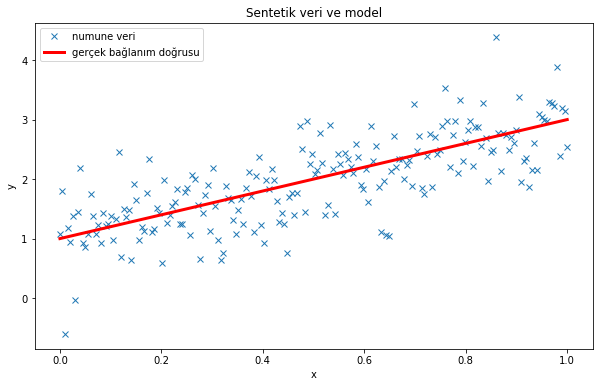

In [3]:
plt.figure(figsize=(10,6))
plt.plot(x, y, 'x', label='numune veri')
plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

## Model kurulumu

Model parametrelerimiz $a,b,\sigma$ için önsellerimizi geniş bir şekilde tanımlayalım:
$$\begin{eqnarray}
\sigma &\sim& \mathrm{Unif}(0,10) \\
a &\sim& N(0,20^2) \\
b &\sim& N(0,20^2)
\end{eqnarray}$$

Olabilirliğimiz, yani modelimiz yukarıda tanımladığımız gibi
$$y_i | x_i,a,b,\sigma^2 \sim N(a+bx_i, \sigma^2)$$

In [4]:
model = pm.Model()
with model:
    # Önselleri tanımla.
    sigma = pm.Uniform('sigma', lower=0,upper=10)
    a = pm.Normal('a', 0, sd=20)
    b = pm.Normal('b', 0, sd=20)

    # Olabilirlik p(y | a,b,sigma)
    likelihood = pm.Normal('y', mu=a + b * x, sd=sigma, observed=y)

    # Kestirim için numune
    zincir = pm.sample(3000) # Sonsal dağılımdan 3000 numune al.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -161.31: 100%|██████████| 200000/200000 [00:23<00:00, 8395.92it/s]
Finished [100%]: Average ELBO = -161.29
100%|██████████| 3000/3000 [00:07<00:00, 410.02it/s]


Monte Carlo numunelerinden çıkan sonsal dağılımlar:

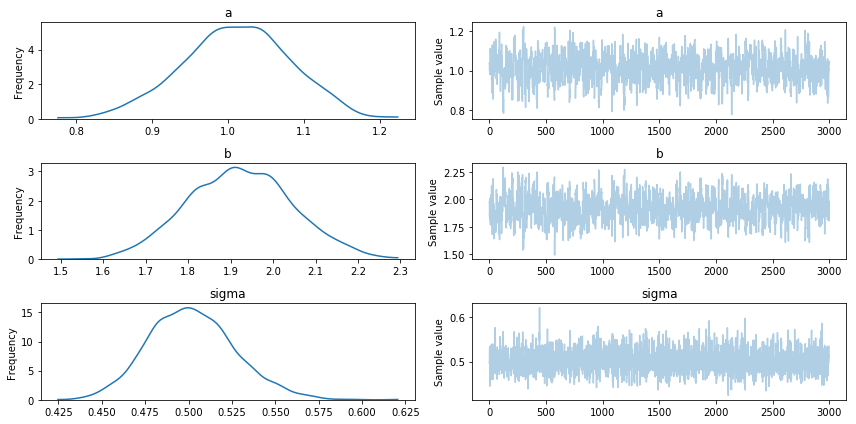

In [5]:
pm.traceplot(zincir);

### Genel doğrusal model kullanarak çözüm

PyMC3 içinde, doğrusal modellere özgü daha basit bir kara kutu da var. Doğrusal bağlanıı `pymc3.glm.glm()` paketiyle şu şekilde yapabiliriz:

Önce verileri etiketlenmiş bir biçime getirelim. Bu etiketler model tanımında kullanılacak. Bir Python sözlüğü, veya pandas dataframe uygundur.

In [6]:
data = dict(x=x, y=y)

In [7]:
with pm.Model() as model:
    # Genel doğrusal modeli Patsy formunda belirt ve veriyi ekle. 
    # Doğrusal model, olabilirlik ve ilgili parametreler otomatik olarak eklenecek.
    pm.glm.glm('y ~ x', data) # model tanımında data'daki etiketler kullanılmalı.
    zincir = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -183.38: 100%|██████████| 200000/200000 [00:27<00:00, 7370.83it/s]
Finished [100%]: Average ELBO = -183.39
100%|██████████| 3000/3000 [00:08<00:00, 599.77it/s]


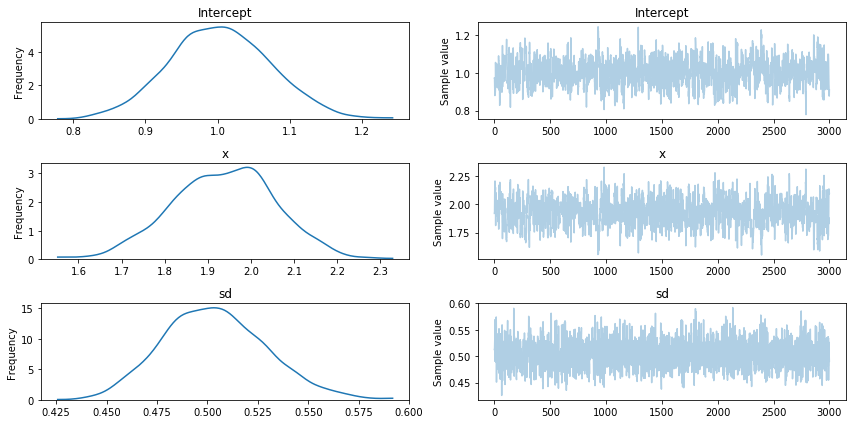

In [8]:
pm.traceplot(zincir);

## Sonsal tahmin (posterior predictive) eğrileri

Sonsal tahminleri kullanmanın bir yolu, numune zinciri içinden bir grubu rastgele seçip, tahmin eğrilerini bu numune değerleriyle çizmektir. Böylece belirsizliği görsel olarak ifade etmemiz mümkün olur.

100 adet parametre çifti seçip ait oldukları doğruları üstüste çizelim.

In [9]:
zincir.varnames

['Intercept', 'x', 'sd_log_', 'sd']

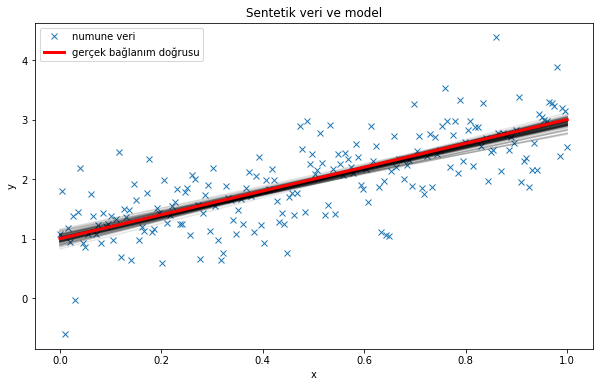

In [10]:
plt.figure(figsize=(10,6))

ppc_ind = np.random.randint(0, 3000, 100)

plt.plot(x, y, 'x', label='numune veri')
for i in ppc_ind:
    a_sonsal = zincir["Intercept"][i]
    b_sonsal = zincir["x"][i]
    plt.plot(x, a_sonsal + b_sonsal*x, "k", alpha=0.1)

plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

Gördüğümüz gibi tahminler çok fazla değişkenlik göstermiyor ve gerçek doğruya göre bir yanlılık yok.

## Uç örnekler, sağlam bağlanım (robust regression)

Verilerimize yapay olarak üç tane uç örnek (outlier) ekleyelim ve analizi tekrarlayalım.

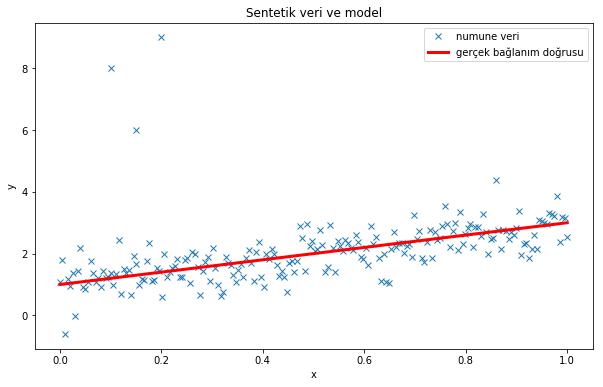

In [11]:
x_uç = np.append(x, [.1, .15, .2])
y_uç = np.append(y, [8, 6, 9])

plt.figure(figsize=(10,6))
plt.plot(x_uç, y_uç, 'x', label='numune veri')
plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend(loc=0);

In [12]:
model = pm.Model()
with model:
    # Önselleri tanımla.
    sigma = pm.Uniform('sigma', lower=0,upper=10, testval=1.)
    a = pm.Normal('a', 0, sd=20)
    b = pm.Normal('b', 0, sd=20)

    # Olabilirlik
    likelihood = pm.Normal('y', mu = a + b * x_uç, sd=sigma, observed=y_uç)

    zincir = pm.sample(3000) # Sonsal dağılımdan 3000 numune çek.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -286.32: 100%|██████████| 200000/200000 [00:24<00:00, 8314.73it/s]
Finished [100%]: Average ELBO = -286.33
100%|██████████| 3000/3000 [00:07<00:00, 388.72it/s]


Sonsal tahmin eğrilerini çizdiğimizde, uç örneklerin tahminleri çok etkilediğini görüyoruz. Sonsal doğrular bariz bir şekilde uç örneklere doğru kaymış.

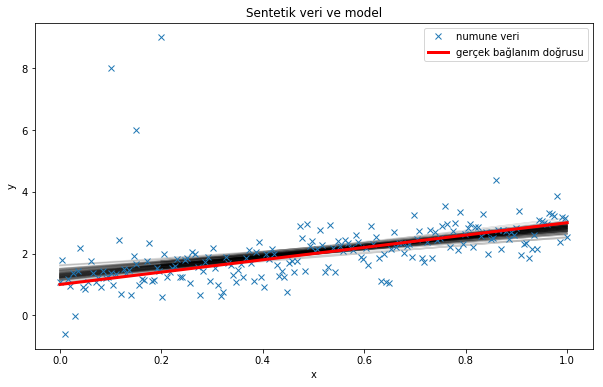

In [13]:
plt.figure(figsize=(10,6))
ppc_ind = np.random.randint(1000, 3000, 100)
for i in ppc_ind:
    a_sonsal = zincir["a"][i]
    b_sonsal = zincir["b"][i]
    plt.plot(x_uç, a_sonsal + b_sonsal*x_uç, "k", alpha=0.1)

plt.plot(x_uç, y_uç, 'x', label='numune veri')
plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

Bu sorunu gidermenin yollarından biri, hataların normal dağıldığı varsayımını terketmektir. Uç örneklerin ortaya çıkabileceği bir dağılım, mesela Student-t dağılımı kullanılabilir. Bu dağılımın etekleri normal dağılım kadar hızlı düşmez.

Student-t dağılımı ortalama ve sapmanın yanı sıra, bir de serbestlik derecesi parametresi ister. Bunu alıştığımız yöntemle çözerken serbestlik derecesini ayrı bir rastgele değişken olarak modele ekleyebiliriz. Veya daha kısa olarak, genel doğrusal model fonksiyonunu Student-t dağılım ailesi ile çalıştırabiliriz.

In [14]:
data = dict(x=x_uç, y=y_uç)
with pm.Model() as model:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.StudentT())
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -223.39: 100%|██████████| 200000/200000 [00:28<00:00, 6911.75it/s]
Finished [100%]: Average ELBO = -223.4
100%|██████████| 3000/3000 [00:08<00:00, 338.14it/s]


Yeni çözümde sonsal tahmin eğrilerinin aşırı uçlardan daha az etkilendiğini görüyoruz.

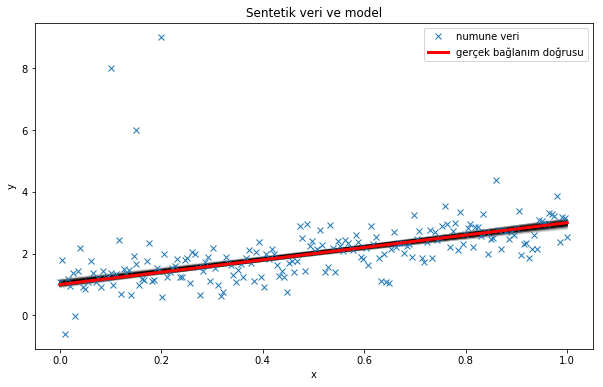

In [15]:
plt.figure(figsize=(10,6))
ppc_ind = np.random.randint(1000, 3000, 100)
for i in ppc_ind:
    a_sonsal = trace["Intercept"][i]
    b_sonsal = trace["x"][i]
    plt.plot(x_uç, a_sonsal + b_sonsal*x_uç, "k", alpha=0.1)

plt.plot(x_uç, y_uç, 'x', label='numune veri')
plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

## Çalışma

1. $y = 1 - 2x +3 x^2$ ($0\leq x\leq 1$) üzerine rastgele gürültü ekleyerek sentetik veri elde edin ve grafiğini çizdirin. $x_1=x, x_2=x^2$ şeklinde değişkenler tanımlayın ve verileri eğitin. Ortaya çıkan sonsal eğrileri gerçek eğriyle beraber çizdirin.

2. Yukarıdaki ikinci derece fonksiyona üç adet uç örnek ekleyin ve sağlam bağlanım uygulayarak sonsal parametreleri bulun. Sonsal eğrileri çizdirin.

## Çözüm

In [5]:
m = 200
a_gerçek = 1
b_gerçek = -2
c_gerçek = 3
x = np.linspace(0, 1, m)
y_gerçek = a_gerçek + b_gerçek*x + c_gerçek*x**2
y = y_gerçek + np.random.normal(scale=.2, size=m)

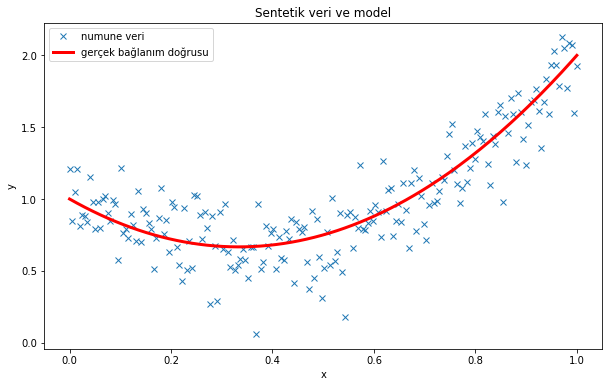

In [6]:
plt.figure(figsize=(10,6))
plt.plot(x, y, 'x', label='numune veri')
plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

In [7]:
model = pm.Model()
with model:
    # Önselleri tanımla.
    sigma = pm.Uniform('sigma', lower=0,upper=10, testval=1.)
    a = pm.Normal('a', 0, sd=20)
    b = pm.Normal('b', 0, sd=20)
    c = pm.Normal("c", 0, sd=20)

    # Olabilirlik
    likelihood = pm.Normal('y', mu = a + b * x + c*x*x, sd=sigma, observed=y)

    zincir = pm.sample(3000) # Sonsal dağılımdan 3000 numune çek.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 27.92: 100%|██████████| 200000/200000 [00:32<00:00, 6194.52it/s] 
Finished [100%]: Average ELBO = 27.949
100%|██████████| 3000/3000 [00:23<00:00, 127.91it/s]


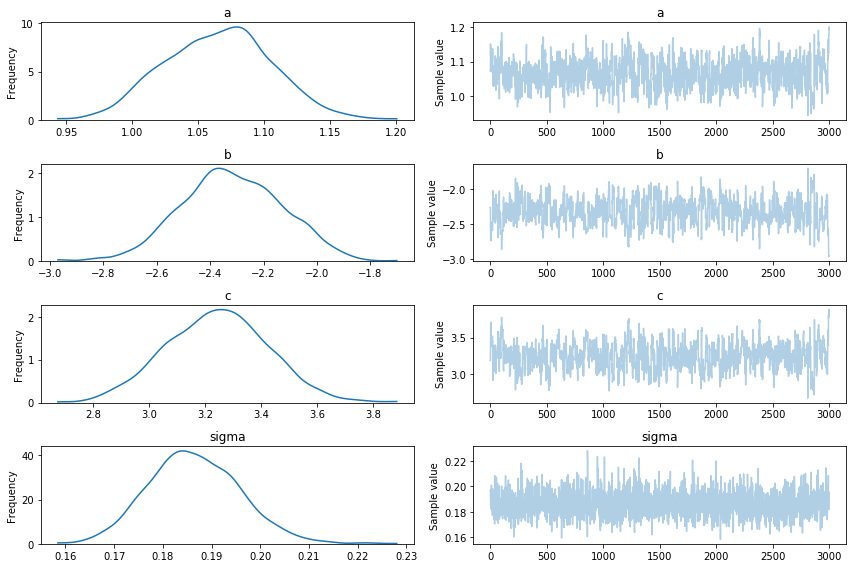

In [9]:
pm.traceplot(zincir);

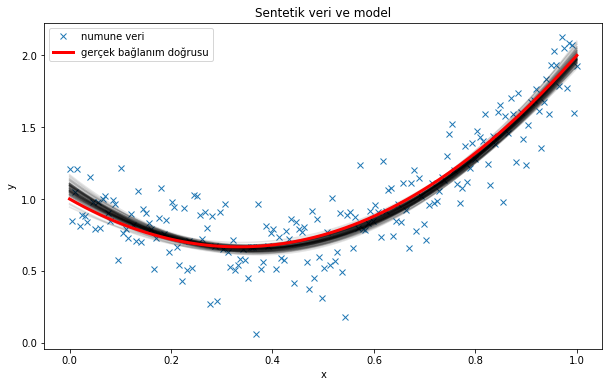

In [10]:
plt.figure(figsize=(10,6))

ppc_ind = np.random.randint(0, 3000, 100)

plt.plot(x, y, 'x', label='numune veri')
for i in ppc_ind:
    a_sonsal = zincir["a"][i]
    b_sonsal = zincir["b"][i]
    c_sonsal = zincir["c"][i]
    plt.plot(x, a_sonsal + b_sonsal*x + c_sonsal*x**2, "k", alpha=0.1)

plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

In [11]:
data = dict(x1=x, x2=x**2, y=y)
with pm.Model() as model:
    pm.glm.glm('y ~ x1 + x2', data) #, family=pm.glm.families.StudentT())
    zincir = pm.sample(3000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.917: 100%|██████████| 200000/200000 [00:33<00:00, 5977.99it/s] 
Finished [100%]: Average ELBO = -4.9185
100%|██████████| 3000/3000 [00:25<00:00, 118.82it/s]


In [13]:
zincir.varnames

['Intercept', 'x1', 'x2', 'sd_log_', 'sd']

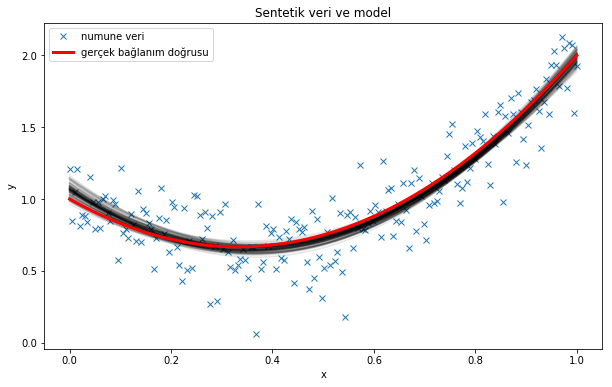

In [14]:
plt.figure(figsize=(10,6))

ppc_ind = np.random.randint(0, 3000, 100)

plt.plot(x, y, 'x', label='numune veri')
for i in ppc_ind:
    a_sonsal = zincir["Intercept"][i]
    b_sonsal = zincir["x1"][i]
    c_sonsal = zincir["x2"][i]
    plt.plot(x, a_sonsal + b_sonsal*x + c_sonsal*x**2, "k", alpha=0.1)

plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -36.839: 100%|██████████| 200000/200000 [00:35<00:00, 5693.38it/s]
Finished [100%]: Average ELBO = -36.795
100%|██████████| 3000/3000 [00:28<00:00, 103.69it/s]


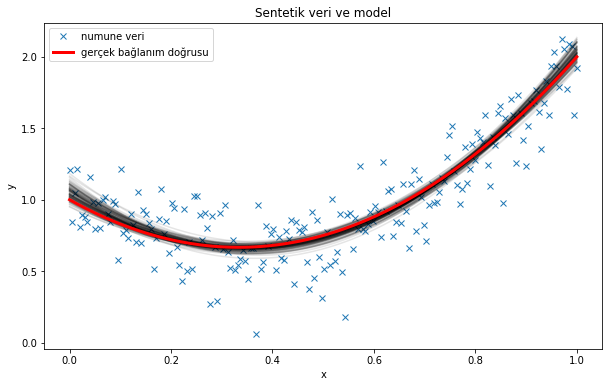

In [15]:
data = dict(x1=x, x2=x**2, y=y)
with pm.Model() as model:
    pm.glm.glm('y ~ x1 + x2', data, family=pm.glm.families.StudentT())
    zincir = pm.sample(3000)

plt.figure(figsize=(10,6))

ppc_ind = np.random.randint(0, 3000, 100)

plt.plot(x, y, 'x', label='numune veri')
for i in ppc_ind:
    a_sonsal = zincir["Intercept"][i]
    b_sonsal = zincir["x1"][i]
    c_sonsal = zincir["x2"][i]
    plt.plot(x, a_sonsal + b_sonsal*x + c_sonsal*x**2, "k", alpha=0.1)

plt.plot(x, y_gerçek, label='gerçek bağlanım doğrusu', lw=3, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sentetik veri ve model')
plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13bc087d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f13c41b9c18>]], dtype=object)

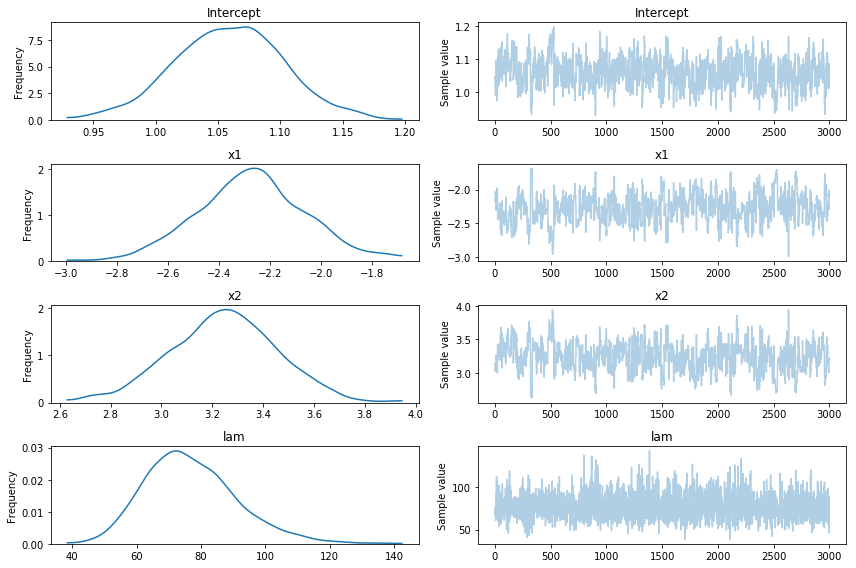

In [16]:
pm.traceplot(zincir)